In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from Module.functional_ZSSSL import run_zsssl_singleecho_singlecoil
from Module.fft import ifft2c, fft2c
from Network.SSDU3D import UnrollModel
from Module.sampling import *


In [2]:
SNR = 15

In [3]:
load_path =f"data/phantom_SNR{SNR}.npy"
image = np.load(load_path)
H, W = image.shape
ksp = fft2c(image).reshape(1, H, W)

N, H, W = ksp.shape

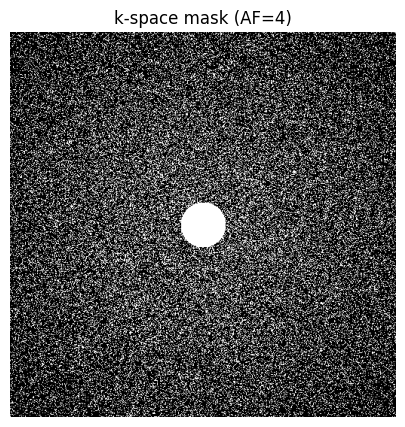

In [4]:
#mask
pattern = "gaussian"
factor = 1/4
radius = 30
std_scale = 2
seed = 100

if pattern == "gaussian":
    mask = gaussian_pattern_acs(pattern_shape=(H,W), factor=factor, radius=radius, std_scale=std_scale, seed=int(seed))
if pattern == "uniform":
    mask = uniform_pattern_acs(pattern_shape=(H,W), factor=factor, radius=radius,seed=int(seed))
mask = mask.astype(np.bool_)

save_root = os.path.join(f"result/AF{int(1/factor)}/SNR{SNR}")

plt.figure(figsize=(10, 5))
plt.title(f'k-space mask (AF={int(1/factor)})')
plt.imshow(mask, 'gray')
plt.axis('off')

plt.show()

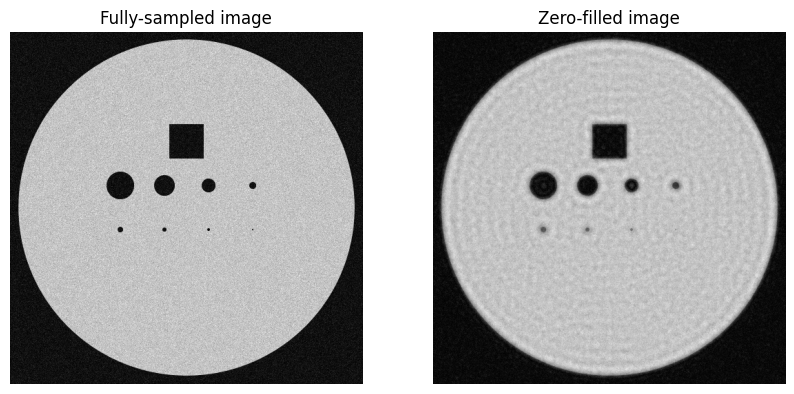

In [5]:
y_u = ksp * mask

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Fully-sampled image')
plt.imshow(abs(image), 'gray', vmax=abs(image).max())
plt.axis('off')

plt.subplot(122)
plt.title('Zero-filled image')
plt.imshow(abs(ifft2c(y_u[0])), 'gray', vmax=abs(image).max())
plt.axis('off')

plt.show()

In [6]:
n_filter = 64
lr=5e-4
batch_size = 2
n_epoch = 1000
early_stop = 20

os.makedirs(save_root, exist_ok=True)

network = UnrollModel(n_filter = n_filter, n_layers = 5, k_iters = 7, with_sharing = True, n_echo = 1)
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
rec_volume, network = run_zsssl_singleecho_singlecoil(
    #y_u         : fully-sampled k-space : (np.complex64) N x H x W
    #mask        : sampling mask         : (np.bool_)         H x W
    # necessary parameter
    y_u, mask, network, optimizer,
    # retrospective settings
    y = ksp, 
    # save & path_settings
    work_dir = save_root, cache_dir = "cache", store_cache = False, 
    save_npyfile = True, save_imgfile = False, cache_division = 1,
    # Zero-Shot SSL hyperparameters
    n_rep = 10, rho = 0.4, val_rho = 0.2, small_acs_block=(12, 12),
    # training settings
    device = torch.device('cuda'),
    batch_size = batch_size, n_epoch = n_epoch, early_stop = early_stop
    )

preprocessing start
Now N: 0 to 0 is processing


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


training start


1it [00:03,  3.47s/it]
1it [00:00,  3.30it/s]


1 epoch end. [Record] train_loss = 0.905, val_loss = 0.695, best_ep = 0


0it [00:00, ?it/s]


KeyboardInterrupt: 

In [ ]:
fs = np.load(os.path.join(save_root, 'results/ref.npy'))
zf = np.load(os.path.join(save_root, 'results/zf.npy'))
rec = np.load(os.path.join(save_root, 'results/rec.npy'))

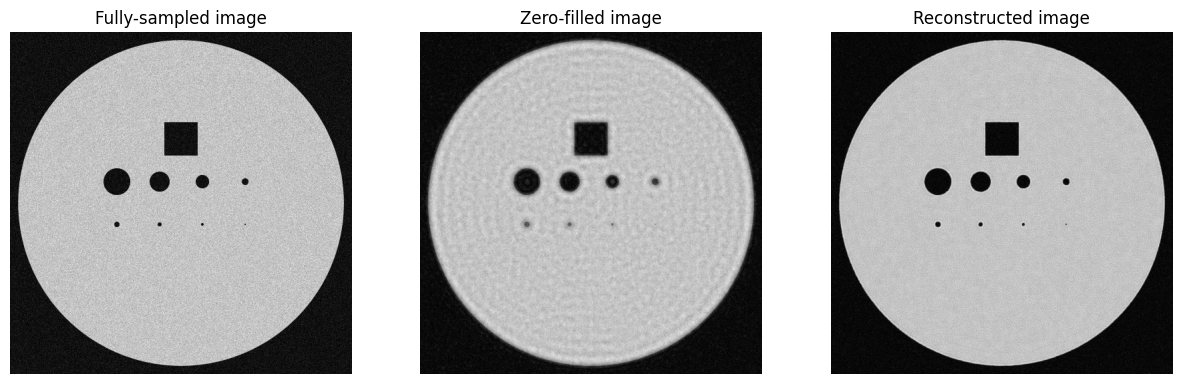

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title('Fully-sampled image')
plt.imshow(abs(fs[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.subplot(132)
plt.title('Zero-filled image')
plt.imshow(abs(zf[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.subplot(133)
plt.title('Reconstructed image')
plt.imshow(abs(rec[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.show()